In [85]:
import pandas as pd
import numpy as np
from IPython.display import display

df = pd.read_csv("./bin/q2/data.csv")
df.drop('Index', axis=1, inplace=True)
display(df.iloc[:2])

X = df.to_numpy().astype(np.float32)
for i in range(X.shape[1]):
    X[:,i] = np.divide(X[:,i]-np.min(X[:,i]), np.max(X[:,i])-np.min(X[:,i]))
print(X[:2])
print(X.shape)

,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,67,2,124670,1,2
1,1,1,22,1,150773,1,2


[[0.         0.         0.8448276  0.6666667  0.324781   0.5
  1.        ]
 [1.         1.         0.06896552 0.33333334 0.42021042 0.5
  1.        ]]
(2000, 7)


In [86]:
import numpy as np
import random
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

class GMM():
    import numpy as np
    def __init__(self, output = True) -> None:
        self.K = 0
        self.means = None
        self.covs = None
        self.weights = None
        self.output = output
        return None

    def initialise(self,X,K):
        N = len(X)
        d = len(X[0])
        self.K = K
        self.means = np.array([X[i] for i in np.random.choice(N,K)])
        self.covs = np.array([np.eye(d,d) for i in range(K)])
        self.weights = np.ones(K)/K
        return None

    def gaussianpdf(self,x):
        d = len(x)
        means = self.means
        covs = self.covs
        diffs = (x.reshape(1,d) - means.reshape(self.K,d)).reshape(self.K,1,d)
        diffsT = np.array([diffs[i].T for i in range(len(diffs))])
        cov_invs = np.linalg.inv(covs)

        exponents = np.array([-0.5 * np.dot(diffs[i], np.dot(cov_invs[i], diffsT[i])) for i in range(self.K)]).flatten()
        denominators = (2 * np.pi) ** (d / 2) * np.sqrt(np.linalg.det(covs))
        pdf = np.exp(exponents)/denominators
        return pdf

    def membershipValues(self,X):
        gammas = []
        N = len(X)
        d = len(X[0])
        gammas = np.zeros((N,self.K))
        for i in range(N):
            gammasK = self.gaussianpdf(X[i])
            gammas[i] = gammasK/np.sum(gammasK)
        return gammas

    def updateParams(self,X,gammas):
        N = len(X)
        d = len(X[0])
        epsilon = 1e-6
        regularisationThreshold = 1e-8

        Nk = np.sum(gammas,axis=0)
        newMeans = []
        newCovs = []
        for k in range(self.K):
            # Calculate tempMean
            tempMean = np.sum((gammas[:, k][:, np.newaxis] * X), axis=0) / Nk[k]

            # Calculate tempCov
            diff = X - self.means[k]
            tempCov = np.sum((gammas[:, k][:, np.newaxis, np.newaxis] * np.einsum('ij,ik->ijk', diff, diff)), axis=0) / Nk[k]

            # Regularization
            det_tempCov = np.linalg.det(tempCov)
            if det_tempCov <= regularisationThreshold:
                tempCov += epsilon * np.eye(d)

            newCovs.append(tempCov)
            newMeans.append(tempMean)

        newMeans = np.array(newMeans)
        newCovs = np.array(newCovs)
        newWeights = np.divide(Nk,N)
        self.means = newMeans
        self.covs = newCovs
        self.weights = newWeights
        return None
    
    def calcLogLikelihood(self, X):
        N = len(X)
        log_likelihood = 0

        for i in range(N):
            pdfs = self.weights * self.gaussianpdf(X[i])  # Calculate Gaussian component probabilities
            log_likelihood += np.log(np.sum(pdfs))  # Sum the log probabilities

        return log_likelihood

    def getLabels(self,X):
        N = len(X)
        labels = []
        gammas = self.membershipValues(X)
        for i in range(N):
            labels.append(1+np.argsort(gammas[i])[-1])
        return np.array(labels)

    def fit(self, data, number_of_clusters, iterations = 100):
        self.initialise(data,number_of_clusters)
        X = np.copy(data)
        plotX = []
        plotY = []
        prev_l = self.calcLogLikelihood(X)
        for i in range(iterations):
            # E step
            gammas = self.membershipValues(X)
            # M step
            self.updateParams(X,gammas)
            # checking for convergence
            final_l = self.calcLogLikelihood(X)
            plotX.append(i+1)
            plotY.append(final_l)
            # print(f"After {i+1} EM iterations: log likelihood = \t {final_l}")
            if (abs(final_l-prev_l) <= 1e-6):
                if (self.output): print(f"Converged in {i+1} iterations of EM")
                return plotX,plotY
            prev_l = final_l
        if (self.output): print(f"Ran till {iterations} iterations of EM")
        return plotX,plotY

    def calculate_aic_bic(self,X):
        # Calculate log-likelihood using score_samples
        log_likelihood = self.calcLogLikelihood(X)

        n_samples, n_features = X.shape
        n_params = self.K * (n_features + n_features + 1)

        aic = -2 * log_likelihood + 2 * n_params
        bic = -2 * log_likelihood + 2 * n_params * np.log(n_samples)

        return aic, bic

In [87]:
import matplotlib.pyplot as plt
model0 = GMM()
plotX, plotY = model0.fit(X,5)

Converged in 28 iterations of EM


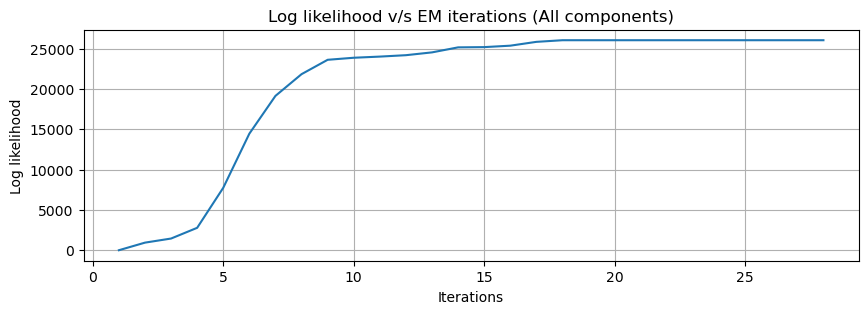

In [88]:
plt.figure(figsize=(10,3))
plt.plot(plotX,plotY)
plt.xlabel("Iterations")
plt.ylabel("Log likelihood")
plt.title("Log likelihood v/s EM iterations (All components)")
plt.grid()
plt.show()

(2000, 7)
(2000, 3)
Ran till 100 iterations of EM


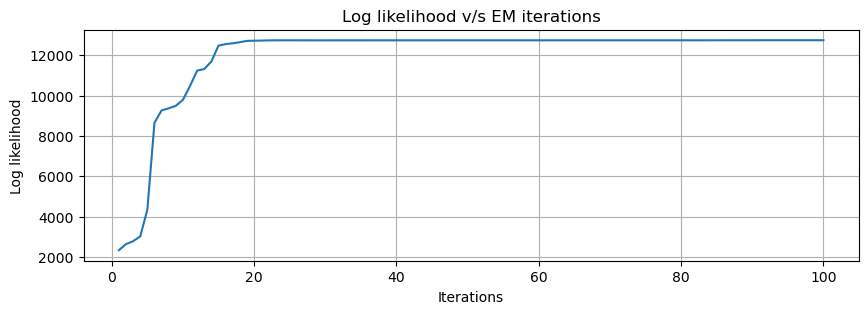

In [89]:
### Varying number of components
import matplotlib.pyplot as plt
print(X.shape)
X = X[:,2:-2] # reDucing number of components
print(X.shape)
model0 = GMM()
plotX, plotY = model0.fit(X,5)

plt.figure(figsize=(10,3))
plt.plot(plotX,plotY)
plt.xlabel("Iterations")
plt.ylabel("Log likelihood")
plt.title("Log likelihood v/s EM iterations")
plt.grid()
plt.show()

### Wine Dataset

In [90]:
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt

X,y = load_wine(return_X_y=True)

for i in range(X.shape[1]):
    X[:,i] = np.divide(X[:,i]-np.min(X[:,i]), np.max(X[:,i])-np.min(X[:,i]))

#### AIC BIC plots

In [91]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
eVectors = pca.components_

In [92]:
print(eVectors.shape)
print(X.shape)
Xtransformed = X @ eVectors.T
print(Xtransformed.shape)

(2, 13)
(178, 13)
(178, 2)


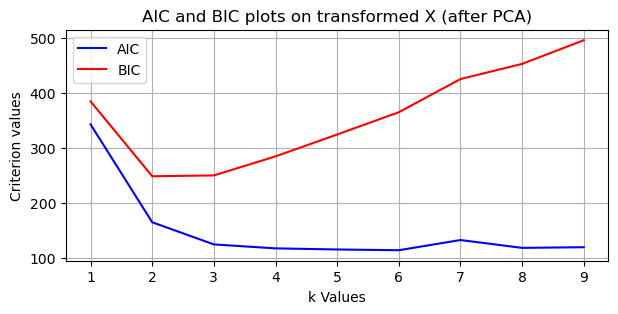

In [93]:
AIClist = []
BIClist = []
kValues = []
for k in range(1,10):
    model2 = GMM(output = False)
    model2.fit(Xtransformed,k)
    
    AICtemp, BICtemp = model2.calculate_aic_bic(Xtransformed)
    kValues.append(k)
    AIClist.append(AICtemp)
    BIClist.append(BICtemp)

import matplotlib.pyplot as plt

plt.figure(figsize=(7,3))
plt.plot(kValues,AIClist,c="blue",label="AIC")
plt.plot(kValues,BIClist,c="red",label="BIC")
plt.xlabel("k Values")
plt.ylabel("Criterion values")
plt.title("AIC and BIC plots on transformed X (after PCA)")
plt.legend()
plt.grid()
plt.show()

From the above graph it can be seen that optimal K (keeping complexity and performance in mind) would be = 3

#### Scatter plots

Converged in 77 iterations of EM


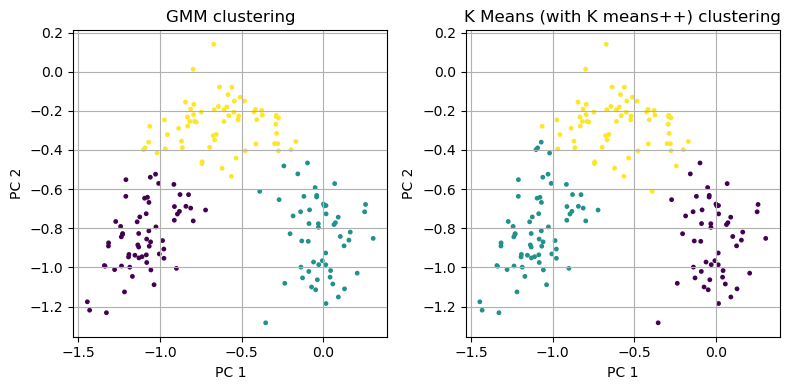

In [94]:
wineK = 3

model1 = GMM()
plotX, plotY = model1.fit(Xtransformed,wineK)
labels1 = model1.getLabels(Xtransformed)

kmeans = KMeans(n_clusters=wineK, n_init=1, init='k-means++')
kmeans.fit(Xtransformed)
labels2 = kmeans.labels_

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.scatter(x = Xtransformed[:,0], y = Xtransformed[:,1], s=6, c=labels1)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("GMM clustering")
plt.grid()

plt.subplot(1,2,2)
plt.scatter(x = Xtransformed[:,0], y = Xtransformed[:,1], s=6, c=labels2)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("K Means (with K means++) clustering")
plt.grid()

plt.tight_layout()
plt.show()


As we can see, since data here is present in sort of spherical regions, K means gives a better result than GMM clustering.

K-means is often used for scenarios where you want to partition data into well-defined, non-overlapping clusters, such as customer segmentation based on purchase behavior.
GMM is suitable when the underlying data distribution is not known in advance, or when you want to capture uncertainty in cluster assignments, like in image segmentation or speaker identification.

#### Silhouette Scores

In [95]:
from sklearn.metrics import silhouette_score

# Assuming you have performed clustering and have cluster labels in 'labels' (an array-like object)
# and your data in 'X' (an array-like object)

# Compute the silhouette score
silhouette_avgGMM = silhouette_score(Xtransformed, labels1)
print(f"Silhouette Score (GMM): {silhouette_avgGMM}")
silhouette_avgKMeans = silhouette_score(Xtransformed, labels2)
print(f"Silhouette Score (K Means): {silhouette_avgKMeans}")

Silhouette Score (GMM): 0.5659673449712417
Silhouette Score (K Means): 0.5680591392935428


The silhouette score is a measure used to evaluate the quality of clusters in a dataset. It provides a way to assess how well-separated the clusters are, taking into account both the distance between data points within the same cluster (intra-cluster distance) and the distance between data points in different clusters (inter-cluster distance). A higher silhouette score indicates better-defined, more separated clusters, while a lower score suggests that the clusters may be overlapping or poorly defined.

If the silhouette score for K-means clustering is higher than that for GMM for a given dataset, it suggests that K-means is better at producing well-separated and distinct clusters for that particular dataset.